# Predicting FIFA 23 Player Ratings

Now that FIFA 23 is out, I have more data to work with for predicting player ratings. I will perform some basic feature engineering to decrease the number of variables first, followed by some Exploratory Data Analysis. After that, I will run a few different 'base' models without adjusting Hyperparameters. After which, I will perform an 'Informed Search' on the best model. An 'Informed Search' is when you first run a somewhat large Randomized search to find a smaller range for each Hyperparameter that performs well. After this, you run a Grid Search on the small range of Hyperparameter values to find the best model.

### Update 3/22/23:
When I went to download the data for the 2022 World Cup, I realized that [fbref.com](https://fbref.com/en/) had changed the way the data was stored. Some columns were missing in some tables, others were in a different order. After spending some time going through and fixing all of the indexing issues for the web scraping functions, I have a new dataset, with data through the 2021-2022 season that I will use below to predict 'Overall Rating' after performing some exploratory data analysis to see how that data has changed due to the new formatting. 

## Loading in the Data and Feature Engineering

In [1]:
#Loading in required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
data = pd.read_csv('FUT_data.csv')
print(data.shape)

(9395, 82)


After adding data from the 2021-2022 season, we have 9,395 observations, up from around 7,500. 82 variables is quite a bit though, so I will decrease this by combining certain other columns.

In [3]:
print(data.columns)

Index(['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', 'MP',
       'Starts', 'Min', 'Gls', 'Sh', 'SoT', 'Avg_Sh_Dist', 'FK', 'PK', 'PKatt',
       'Cmp', 'Att', 'Pass_TD', 'Pass_PD', 'Cmp_S', 'Att_S', 'Cmp_M', 'Att_M',
       'Cmp_L', 'Att_L', 'Ast', 'KP', 'Pas_A3', 'PPA', 'CrsPA', 'PrgP', 'CrdY',
       'CrdR', '2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 'PKwon', 'PKcon', 'OG',
       'Recov', 'AD_Won', 'AD_Lost', 'Touches', 'Tch_DP', 'Tch_D3', 'Tch_M3',
       'Tch_A3', 'Tch_AP', 'Live', 'TO_Att', 'TO_Succ', 'Tkld', 'Carries',
       'Carries_TD', 'Carries_PD', 'PrgC', 'Carries_A3', 'CPA', 'Mis', 'Dis',
       'Rec', 'PrgR', 'Tkl', 'TklW', 'Tkl_D3', 'Tkl_M3', 'Tkl_A3',
       'Tkl_VD_succ', 'Tkl_VD_att', 'Tkl_VD_lost', 'Blocks', 'Blocked_shot',
       'Blocked_pass', 'Int', 'Clr', 'Err', 'Overall', 'Game'],
      dtype='object')


There are a few different groupings of columns that can be combined, such as 'Cmp_S', 'Cmp_M' and 'Cmp_L'. Doing this for a few different groups of variables will decrease the total number of variables by quite a bit.

In [4]:
drop = ['Cmp_S', 'Att_S', 'Cmp_M', 'Att_M', 'Cmp_L', 'Att_L', 
        'Tch_DP', 'Tch_D3', 'Tch_M3', 'Tch_A3', 'Tch_AP', 'Live',
        'Tkl_D3', 'Tkl_M3', 'Tkl_A3', 'Tkl_VD_att', 'Blocked_shot', 'Blocked_pass']

data = data.drop(drop, axis=1)

print(data.shape)

(9395, 64)


We can see that 18 columns have been removed from the data. Now that Feature Engineering is finished, let's do some Exploratory Data Analysis.

## Exploratory Data Analysis

Since 'Overall' rating is the target variable, let's take a look at it first.

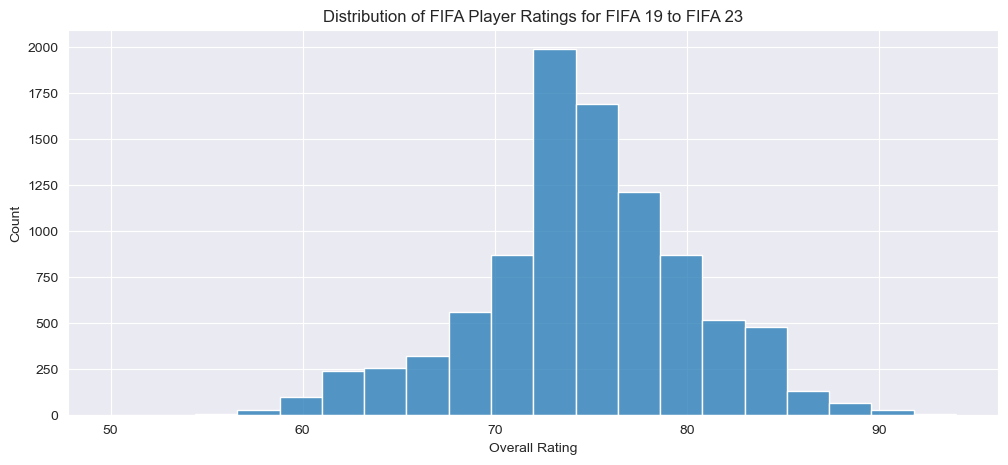

Summary Statistics for "Rating":
count    9395.000000
mean       74.585098
std         5.655242
min        50.000000
25%        71.000000
50%        75.000000
75%        78.000000
max        94.000000
Name: Overall, dtype: float64


In [5]:
sns.set_style('darkgrid')
plt.figure(figsize=(12, 5))
sns.histplot(x='Overall', data=data, bins=20)
plt.title('Distribution of FIFA Player Ratings for FIFA 19 to FIFA 23')
plt.xlabel('Overall Rating')
plt.show()
print('Summary Statistics for "Rating":')
print(data.Overall.describe())

We can see that there is a mean 'Overall' rating of around 75. 50% of the players have a rating between 71 and 78. An IQR of 7 suggests that players with a rating below 61 or above 88 are outliers. The histogram looks roughly normally distributed, with maybe a slight left skew. Let's take a look at the distribution of 'Overall' for each FIFA game next.

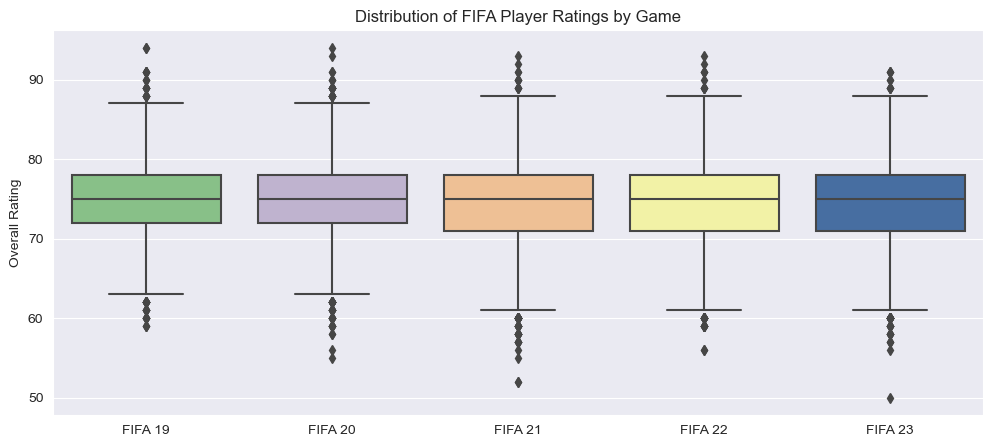

In [6]:
x = ['FIFA 19', 'FIFA 20', 'FIFA 21', 'FIFA 22', 'FIFA 23']
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='Game', y='Overall', data=data, palette='Accent')
ax.set_xticklabels(x)
plt.title('Distribution of FIFA Player Ratings by Game')
plt.xlabel(None)
plt.ylabel('Overall Rating')
plt.show()

The data looks pretty consistent across all the FIFA games, a median of around 75 with 50% of the data falling between 70 and 80. The higher rated players that appear as outliers will be kept, as it makes sense for the elite players to be differentiated as there are not very many players who get a rating in the 90s every year. Let's see if setting a threshold of 'Min', or minutes played, will remove any of the lower rated players, as it seems likely that players who get very little playing time will be the worse players and therefore have a lower rating. 

In [7]:
print('Summary Statistics for Total Minutes Played:')
print(data.Min.describe())

Summary Statistics for Total Minutes Played:
count    9395.000000
mean     1517.900479
std      1021.868457
min         1.000000
25%       625.000000
50%      1482.000000
75%      2324.500000
max      4547.000000
Name: Min, dtype: float64


75% of players in the data have played at least 625 minutes while 50% have played at least 1,482 minutes. A standard football game is 90 minutes. It seems unlikely that an 'Overall' rating could be predicted with very little playing time, so let's set a cut off of 360 minutes, or 4 total games.

In [8]:
x = len(data[data['Min'] < 360])
print('Number of players with less than 360 minutes played:', x)

y = round(x/len(data)*100, 2)
print('\nPercentage of rows:', str(y)+'%')

Number of players with less than 360 minutes played: 1657

Percentage of rows: 17.64%


17.64% of the data might seem like a lot to remove, but we will still be left with almost 8,000 observations. Let's see how removing these players affects the previous graphs.

In [9]:
data = data[data['Min'] >= 360]

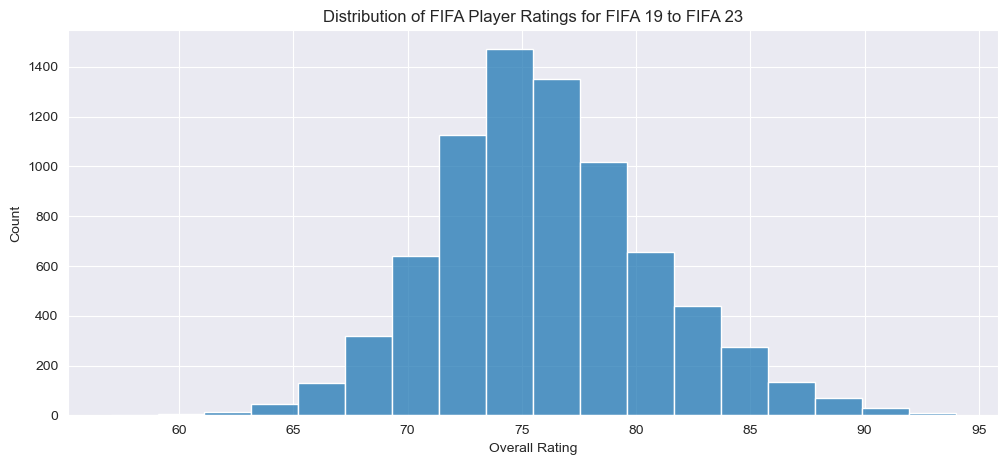

In [10]:
plt.figure(figsize=(12, 5))
sns.histplot(x='Overall', data=data, bins=18)
plt.title('Distribution of FIFA Player Ratings for FIFA 19 to FIFA 23')
plt.xlabel('Overall Rating')
plt.show()

I'd say the histogram of 'Overall' looks slightly better, there is more of a bell shape curve, meaning it looks more normally distributed. There might be a slight right skew now, however, given that it was mostly lower rated players that were removed.

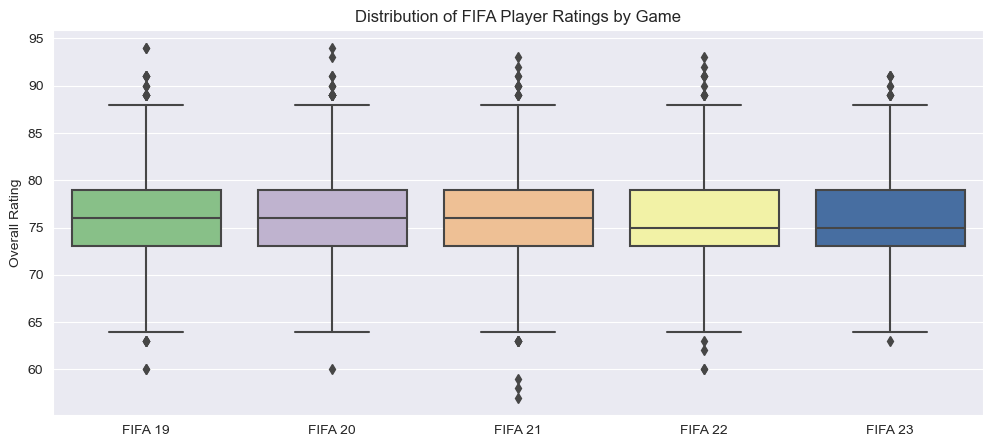

In [11]:
x = ['FIFA 19', 'FIFA 20', 'FIFA 21', 'FIFA 22', 'FIFA 23']
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='Game', y='Overall', data=data, palette='Accent')
ax.set_xticklabels(x)
plt.title('Distribution of FIFA Player Ratings by Game')
plt.xlabel(None)
plt.ylabel('Overall Rating')
plt.show()

After removing players with less than 360 minutes played, we are left with less outliers for lower 'Overall' ratings. This validates my point earlier that the lower rated players likely had played fewer minutes. Let's take a look at a few other variables next, starting with 'Pos', or Position.

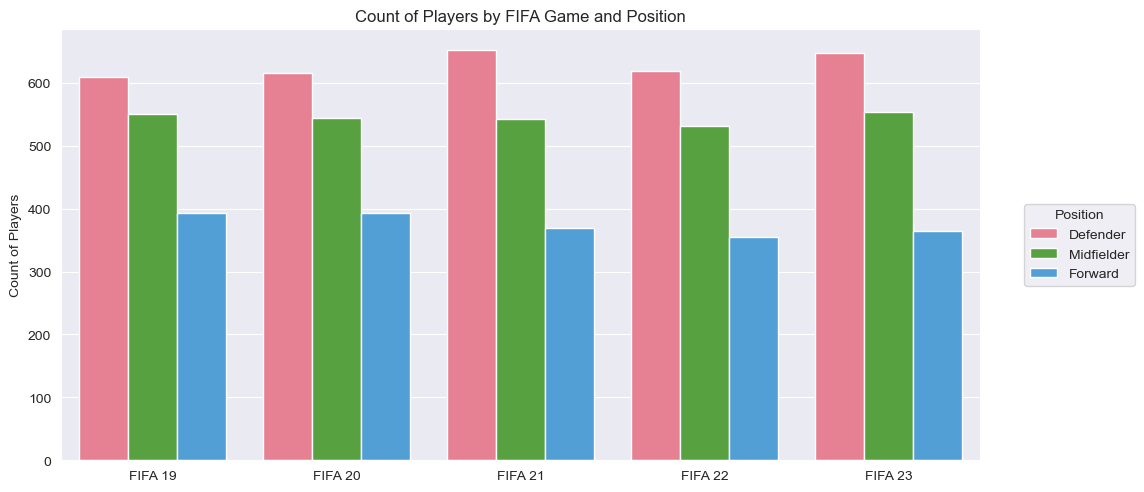

In [12]:
ax = sns.catplot(x='Game', data=data, hue='Pos', kind='count', height=5, aspect=2, legend=False, palette='husl')
ax.set_xticklabels(x)
plt.xlabel(None)
plt.ylabel('Count of Players')
plt.title('Count of Players by FIFA Game and Position')
plt.legend(title = 'Position', labels=['Defender', 'Midfielder', 'Forward'], bbox_to_anchor=(1.04,0.5), loc="center left")
plt.show()

The number of players in each position appears to have stayed the same across all the games. Next, let's see if 'Overall' varies at all by Position.

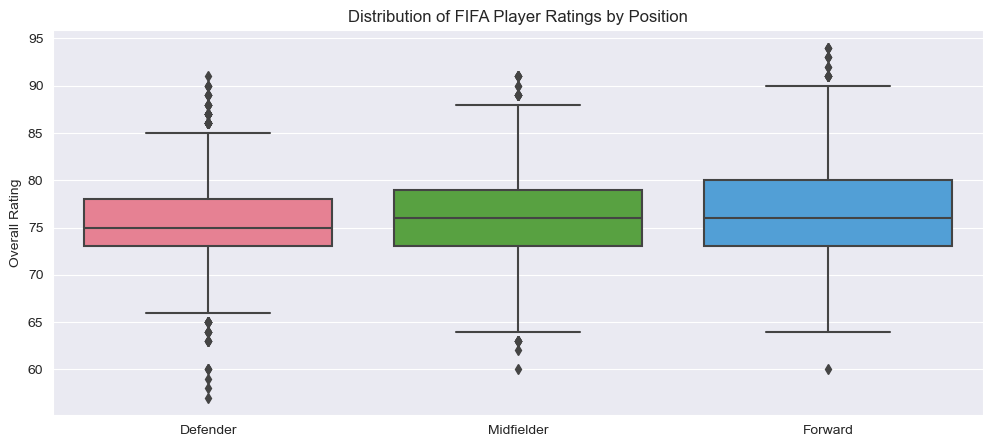

In [13]:
y = ['Defender', 'Midfielder', 'Forward']
plt.figure(figsize=(12, 5))
ax = sns.boxplot(x='Pos', y='Overall', data=data, palette='husl')
ax.set_xticklabels(y)
plt.title('Distribution of FIFA Player Ratings by Position')
plt.xlabel(None)
plt.ylabel('Overall Rating')
plt.show()

From the box plots above, it looks like, on average, Defenders have the lowest 'Overall' rating of all 3 position groups. Forwards appear to have the largest variance in rating, however, with the largest IQR. The median across all three positions, however, is roughly the same at around 75/76. Next, let's look at a cross tabulation of 'Comp', or which League the player is in, and 'Game'.

In [14]:
display(pd.crosstab(data['Comp'], data['Game'], margins=True))

Game,19,20,21,22,23,All
Comp,,,,,,
Bundesliga,299,311,297,297,286,1490
La Liga,268,260,267,253,268,1316
Ligue 1,302,296,285,281,305,1469
Premier League,342,353,355,341,350,1741
Serie A,341,333,359,334,355,1722
All,1552,1553,1563,1506,1564,7738


The table above shows the number of players from each league in each game. We can see that we have a range of 1,506 to 1,564 players from each game, which is pretty balanced. Each league has between 1,316 and 1,741 players present in the data, with both the English Premier League (EPL) and the Italian Serie A having over 1,700. There is some imbalance here, but the range is not too large. It is likely that there are fewer players from the Spanish La Liga and French Ligue 1 due to player's names being stored differently in the real-life game data and the FIFA ratings data; French and Spanish have more accented characters than German, English and Italian, and therefore there were likely less matches. The German Bundesliga also only has 18 teams compared to other leagues all having 20 teams, so that's why the Bundesliga numbers are slightly lower than EPL and Serie A. Let's look at the relationship between 'Comp' and 'Overall' next.

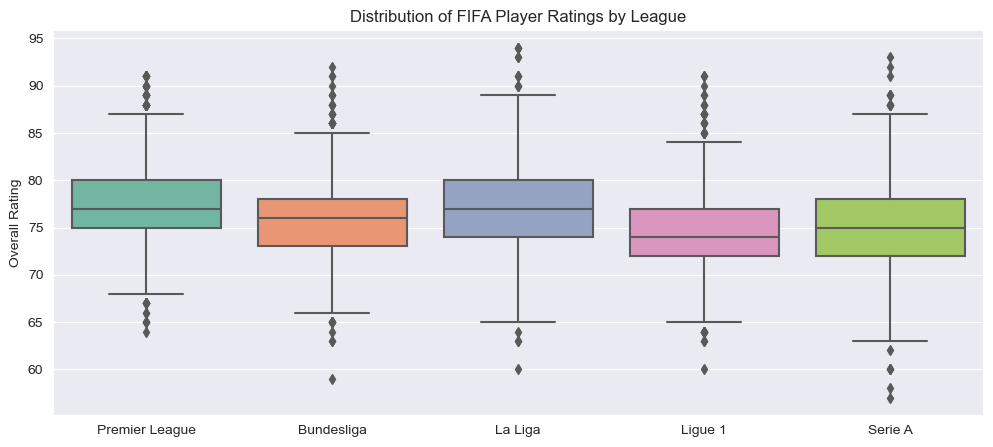

In [15]:
plt.figure(figsize=(12, 5))
sns.boxplot(x='Comp', y='Overall', data=data, palette='Set2')
plt.title('Distribution of FIFA Player Ratings by League')
plt.xlabel(None)
plt.ylabel('Overall Rating')
plt.show()

If you are a big soccer fan, the box plots above should not be surprising. The English Premier League (EPL) and the Spanish La Liga appear to have, on average, higher rated players than the other 3 leagues. These two leagues are often considered the best 2 in the world, so to have higher rated players is not surprising. The German Bundesliga appears to be next highest, followed by the Italian Serie A and lastly by the French League 1. Interestingly, Serie A appears to have the most points viewed as Outliers for lower rated players. Maybe there are more young players in this league? 

Now that we have taken a look at how 'Overall' varies across multiple categorical predictors, let's compare it to a few of the numerical variables.

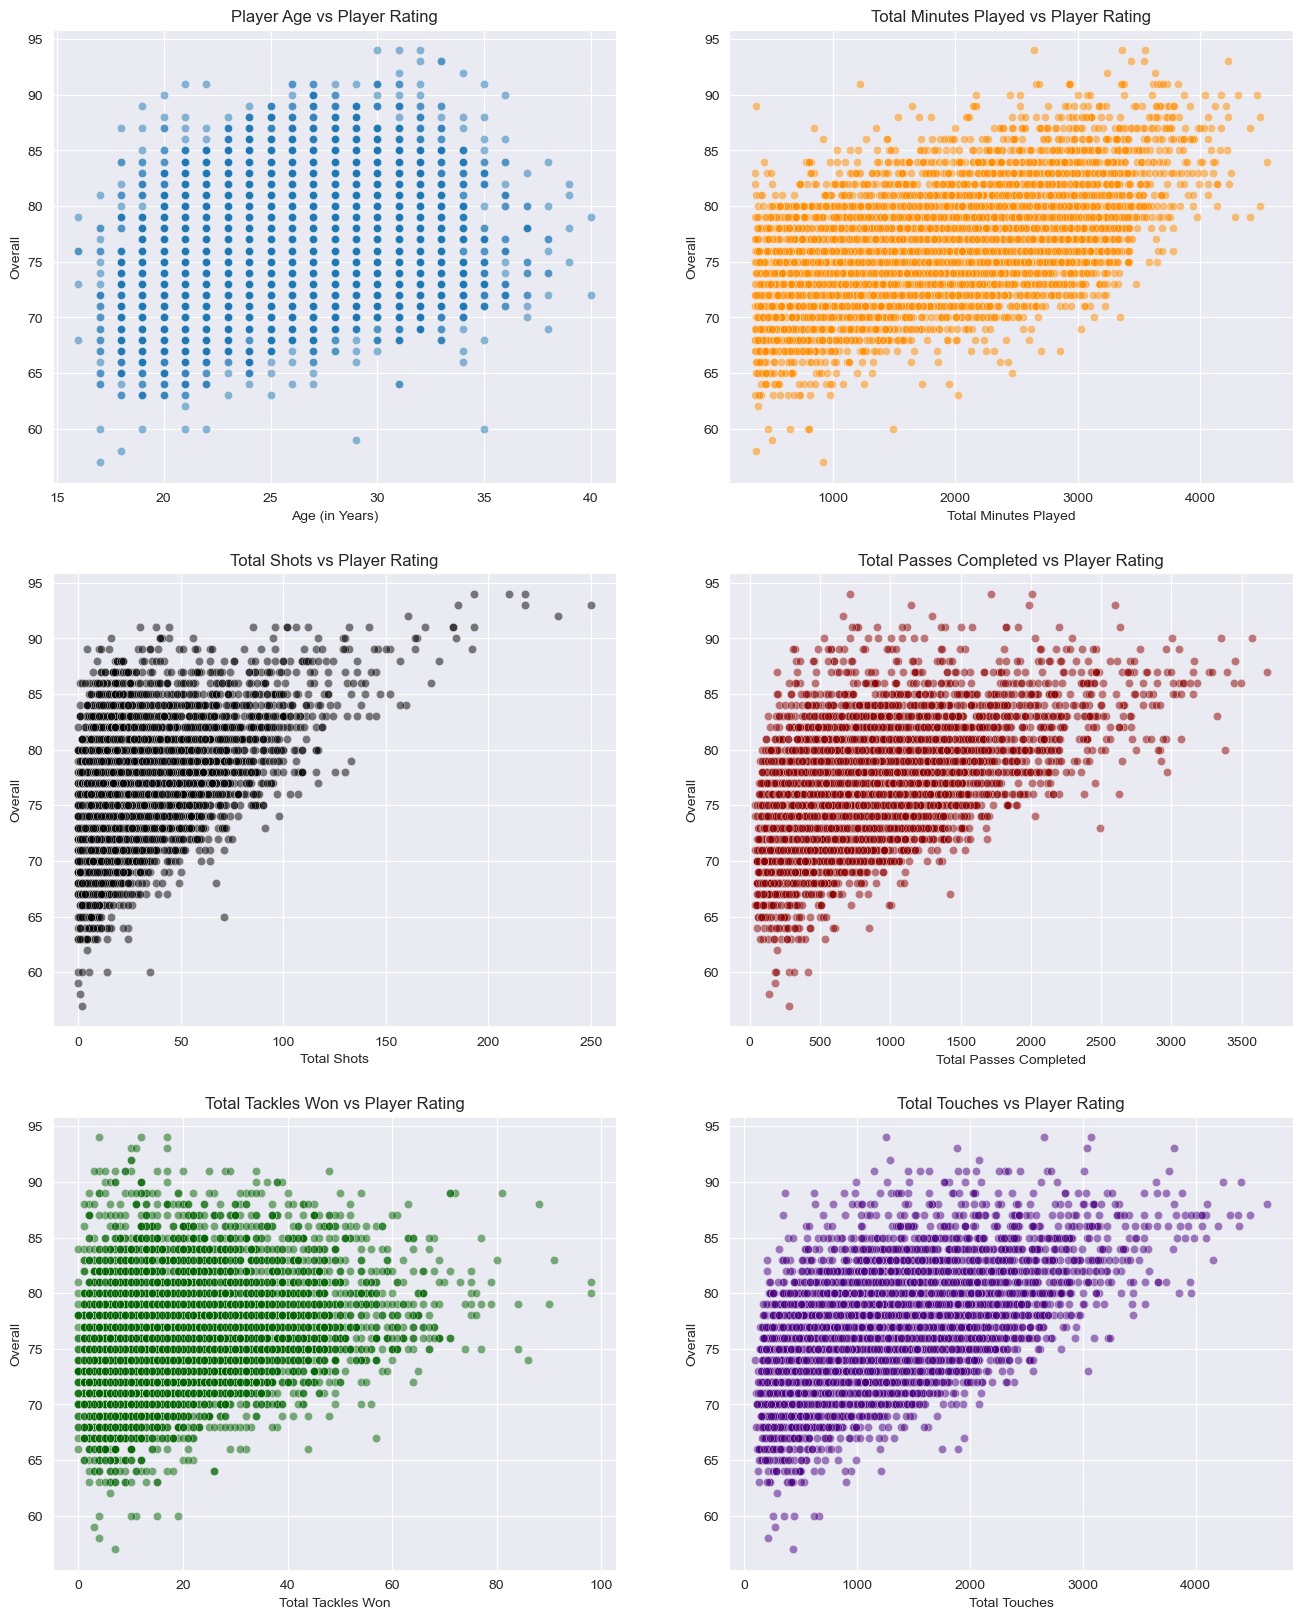

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(16, 20))

sns.scatterplot(ax=axes[0,0], data=data, x='Age', y='Overall', alpha=0.5).set_title('Player Age vs Player Rating')
axes[0,0].set(xlabel='Age (in Years)')

sns.scatterplot(ax=axes[0,1], data=data, x='Min', y='Overall', color='darkorange', 
                alpha=0.5).set_title('Total Minutes Played vs Player Rating')
axes[0,1].set(xlabel='Total Minutes Played')

sns.scatterplot(ax=axes[1,0], data=data, x='Sh', y='Overall', color='black',
                alpha=0.5).set_title('Total Shots vs Player Rating')
axes[1,0].set(xlabel='Total Shots')

sns.scatterplot(ax=axes[1,1], data=data, x='Cmp', y='Overall', color='darkred',
                alpha=0.5).set_title('Total Passes Completed vs Player Rating')
axes[1,1].set(xlabel='Total Passes Completed')

sns.scatterplot(ax=axes[2,0], data=data, x='TklW', y='Overall', color='darkgreen',
                alpha=0.5).set_title('Total Tackles Won vs Player Rating')
axes[2,0].set(xlabel='Total Tackles Won')

sns.scatterplot(ax=axes[2,1], data=data, x='Touches', y='Overall', color='indigo',
                alpha=0.5).set_title('Total Touches vs Player Rating')
axes[2,1].set(xlabel='Total Touches')

plt.show()

The first plot shows 'Age' vs 'Overall'. It looks like the players peak in 'Overall' rating in their late 20s and early 30s, which makes sense as this is usually the players 'prime'. 

The second plot shows 'Minutes Played' vs 'Overall'. There appears to be a moderately strong positive linear relationship between the two; the more minutes you play the higher your rating is likely to be. The majority of players who have played more than 3,000 minutes in the season have a 'Overall' rating above the median of 75.

The third plot shows 'Total Shots' vs 'Overall'. It looks like there is a somewhat positive relationship, but it is definitely not linear. This makes sense though, as Forwards tend to get more shots compared to Defenders and Midfielders, so you cannot hold few shots for a Defender against him. You can see how shots vary by position by looking at high rated players: the majority of players with a 'Overall' above 90 have more than 100 shots in the season, those with less shots are likely to be Defenders. 

The fourth plot shows 'Total Passes' vs 'Overall' Again, we see a somewhat positive relationship here. Interestingly, all of the players with more than 3,000 passes have an 'Overall' rating that is above 80 but below 90. Interestingly, the highest rated players fall in the 500 to 2,000 passses range, likely indicating that they are Forwards. 

The fifth plot shows 'Total Tackles Won' vs 'Overall'. There does not appear to be much of a relationship at all between these two variables. However, just like 'Total Shots', 'Total Tackles Won' is likely influenced by player position, as Defenders get far more tackles than Forwards and Midfielders. We can see a cluster of players in the top left with high ratings and low tackles, which are likely the elite forward players like Lionel Messi, Neymar and Cristiano Ronaldo. 

The last plot shows 'Total Touches' vs 'Overall'. Here we can see a somewhat strong positive linear relationship between the two. This makes sense, as better players are going to be touching the ball more frequently.

Now that we have taken a look at the relationship between 'Overall' rating and some of the predictor variables, let’s start making some models.

## Predicting 'Overall' Rating

In [17]:
#This function will be used to calculate and display the R^2 and RMSE of each model
def evaluate_model(model, x_train, y_train, x_test, y_test):
    start = time.time()
    model.fit(x_train, y_train)
    score = np.round(model.score(x_test, y_test), 4)
    preds = model.predict(x_test)
    rmse = np.round(mean_squared_error(y_test, preds, squared=False), 2)
    end = time.time()
    t = round(end-start, 4)
    print('R^2: {}, RMSE: {}\n'.format(score, rmse))
    print(f'Run Time: {t} seconds')
    return score, rmse, t

scores_list = [] # will be used to display model metrics at the end

### Some last preprocessing of the data

In [18]:
data = data.astype({'Game':'category', 'Comp':'category', 'Pos':'category'}) #change dtype so dummies can be created 

target = data[['Overall']] #target variable

d = data.drop(['Player', 'Nation', 'Squad', 'Born', 'Overall'], axis=1) #remove unneeded columns

features = pd.get_dummies(d, columns=['Pos', 'Comp', 'Game'], drop_first=True) #create dummy variables

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=1996) #train test split

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train) #standardized data

X_test_scaled = scaler.transform(X_test) #transforming test data 

y_train = y_train.values.ravel() #changing format of y_train to array 

### Linear Regression

First I will run a basic Linear Regression model to use a baseline to compare more advanced models against.

In [19]:
#Linear Regression Model
lr = LinearRegression()

lr_r2, lr_rmse, lr_t = evaluate_model(lr, X_train_scaled, y_train, X_test_scaled, y_test)

print(f'\nStandard Deviation of "Overall": {round(target.std(), 3)}')

scores_list.append(['Linear Regression', lr_r2, lr_rmse, lr_t])

R^2: 0.6383, RMSE: 2.79

Run Time: 0.018 seconds

Standard Deviation of "Overall": Overall    4.646
dtype: float64


A $R^{2}$ value of 0.6383 implies that 63.83% of the variance of 'Overall' can be explained by the used predictor variables. A RMSE of 2.79 is lower than the variance of 'Overall', 4.646, indicating that this model is not bad. Next let's try a Random Forest Model.

### Random Forest

In [20]:
rf = RandomForestRegressor(random_state=1996)

rf_r2, rf_rmse, rf_t= evaluate_model(rf, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Random Forest', rf_r2, rf_rmse, rf_t])

R^2: 0.6406, RMSE: 2.78

Run Time: 10.5164 seconds


Our $R^{2}$ value is slightly higher than the Linear Regression Model, but the run time is significantly longer, although still relatively short at roughly 11 seconds. The RMSE is basically the same, improved by 0.01. Let's try a Gradient Boosting Model next.

### Gradient Boosting

In [21]:
gb = GradientBoostingRegressor(random_state=1996)

gb_r2, gb_rmse, gb_t = evaluate_model(gb, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting', gb_r2, gb_rmse, gb_t])

R^2: 0.6542, RMSE: 2.73

Run Time: 3.4012 seconds


This is the best model so far by. Although the run time is longer than the Linear Regression model, it is still short at roughly 3.4 seconds. Let's try some Hyperparameter tuning on a Gradient Boosting Model. I will be doing an 'Informed Search', starting with a Randomized Search on a large parameter grid. The results of the Randomized search will be used to find a smaller range of values to use in a Grid Search. 

In [22]:
#Create paramter grid for GB
max_depth = list(range(5, 26))
learning_rate = np.arange(0.01, 0.21, 0.01).tolist()
n_estimators = np.arange(100, 1050, 50).tolist()
#21*20*19 HP options, roughly 8000 total

gb_params = {'max_depth': max_depth,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators}

In [23]:
gb2 = GradientBoostingRegressor(random_state=1996)

gb_rand = RandomizedSearchCV(gb2, gb_params, n_iter=200, cv=3, verbose=2, n_jobs=-1, random_state=717)

gb_rand.fit(X_train_scaled, y_train)

print(gb_rand.best_params_)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.060000000000000005}


In [24]:
gb_r = GradientBoostingRegressor(n_estimators=300, learning_rate=0.06, max_depth=5, random_state=1996)

gbr_r2, gbr_rmse, gbr_t = evaluate_model(gb_r, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting w/ Random Search', gbr_r2, gbr_rmse, gbr_t])

R^2: 0.6684, RMSE: 2.67

Run Time: 17.4523 seconds


We can see that the best hyperparameter combination found was 300 trees with a max depth of 5 and a learning rate of 0.06. The $R^{2}$ value of 66.84% is the best so far. Let's take a look at some graphs of these 3 hyperparameters to find smaller ranges for each to run a grid search on.

In [25]:
df = pd.DataFrame(gb_rand.cv_results_)
df = df[['params', 'mean_test_score']]
scores = pd.concat([df, df.params.apply(pd.Series)], axis=1)
scores = scores.drop('params', axis=1)

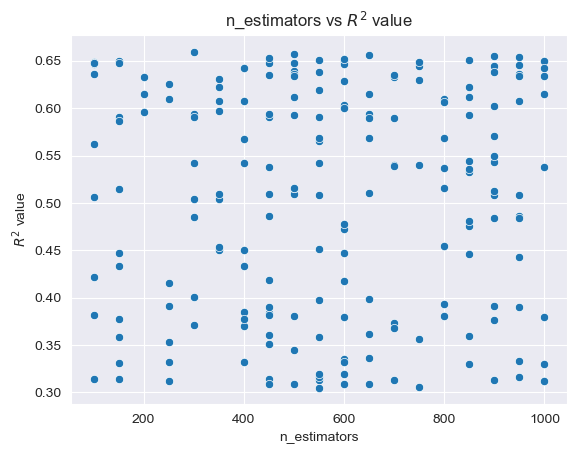

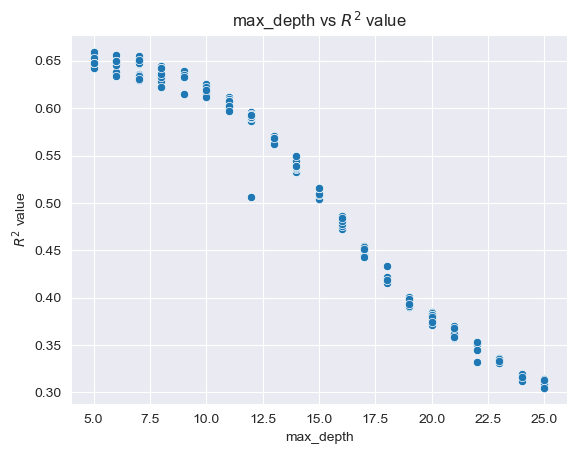

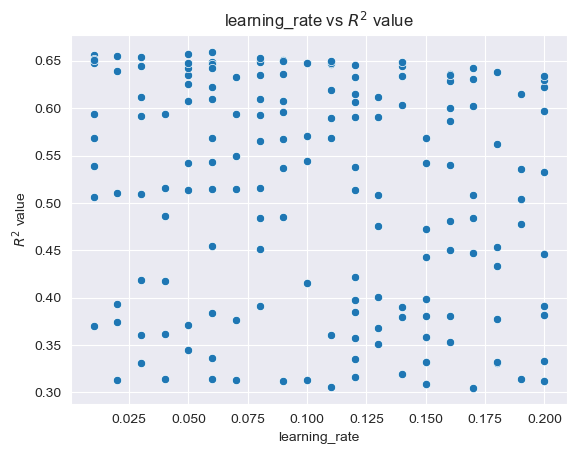

In [26]:
lst = ['n_estimators', 'max_depth', 'learning_rate']

for l in lst:
    sns.scatterplot(x=l, y='mean_test_score', data=scores)
    plt.title(f'{l} vs $R^{2}$ value')
    plt.xlabel(f'{l}')
    plt.ylabel('$R^{2}$ value')
    plt.show()

It looks like 300-600 estimators, a max depth of 5 to 6 and a learning rate of 0.04 to 0.06 are the ranges that should be used in the grid search. 

In [27]:
#Create paramter grid for GB
max_depth = [5, 6]
learning_rate = [0.04, 0.045, 0.05, 0.055, 0.06]
n_estimators = [300, 350, 400, 450, 500, 550, 600]

gb_params = {'max_depth': max_depth,
             'learning_rate': learning_rate,
             'n_estimators': n_estimators}

In [28]:
gb3 = GradientBoostingRegressor(random_state=1996)

gb_grid = GridSearchCV(gb3, gb_params, cv=3, verbose=2, n_jobs=-1)

gb_grid.fit(X_train_scaled, y_train)

print(gb_grid.best_params_)

Fitting 3 folds for each of 70 candidates, totalling 210 fits
{'learning_rate': 0.04, 'max_depth': 5, 'n_estimators': 400}


After running a Grid Search, the best hyperparameter values found were: a Max Depth of 5, 400 estimators and a learning rate of 0.04. Let's see how well this model performs compared to the previous models.

In [29]:
gb_i = GradientBoostingRegressor(n_estimators=400, learning_rate=0.04, max_depth=5, random_state=1996)

gbi_r2, gbi_rmse, gbi_t = evaluate_model(gb_i, X_train_scaled, y_train, X_test_scaled, y_test)

scores_list.append(['Gradient Boosting w/ Informed Search', gbi_r2, gbi_rmse, gbi_t])

R^2: 0.6712, RMSE: 2.66

Run Time: 23.0673 seconds


In [30]:
scores_df = pd.DataFrame(scores_list, columns=['Model Type', 'R^2', 'RMSE', 'Run Time'])
display(scores_df)

,Model Type,R^2,RMSE,Run Time
0,Linear Regression,0.6383,2.79,0.0180
1,Random Forest,0.6406,2.78,10.5164
2,Gradient Boosting,0.6542,2.73,3.4012
3,Gradient Boosting w/ Random Search,0.6684,2.67,17.4523
4,Gradient Boosting w/ Informed Search,0.6712,2.66,23.0673


This last model, Gradient Boosting with an Informed search, performed the best, with an $R^{2}$ of 67.12% and a RMSE of 2.66. This is an improvemnt of 3.29% compared to the Linear regression model, however the run time is significantly logner, but a still somewhat manageable 23 seconds.

## Conclusion

The previous analysis using data through the 2021-2022 season resulted in the best model having a $R^{2}$ of 65.70%. With the new data format for the source data, we have a roughly 1.4% increase in the scoring metric. Again, this is still worse than the models created using data only through the 2020-2021 season. However, as noted before, I believe that these results are reasonable given how 'Overall' Rating is calculated using 6 sub scores in FIFA. These subscores are: Pace (Speed/Acceleration), Shooting, Passing, Dribbling, Defense and Physical. The data used here can account for 4 of these 6 scores, everything but Pace and Physical. 

## Future Work

Some things I could do to attempt to obtain a better model are: 
 - Try changing the variables used:
     - Remove 'Game' from the model
     - Remove the aggregated variables and use the others instead (Remove Total Passes and use Short, Medium, Long, etc.)
 - Add more leagues: it looks like [fbref](https://fbref.com/en/) also recently added more data for more leagues, the last time I looked most other leagues only had 3 of the 6 different tables used
 - Try more model types: since there are a large number of variables, a Neural Network model might perform better